# K-Means Tutorial

Wilkommen zum K-Means Tutorial in Python. In diesem Tutorial werden Sie den *k-means*-Clusteringalgorithmus implementieren und dabei die grundlegenden Kontrollstrukturen von Python sowie den Umgang mit den wichtigsten Bibliotheken lernen. Beginnen wir mit dem importieren von matplotlib und numpy.

## Erstellen der Trainingsdaten

In [129]:
import matplotlib.pyplot as plt
import numpy as np

Um Funktionen aus diesen Bibliotheken zu nutzen, müssen wir den Namen der Bibliothek und den Namen der Funktion mit einem `.` verknüpfen, z.B. `matplotlib.plot()`
Wie Sie sehen können, haben wir für die Bibliothek numpy das alias np vergeben, sodass wir Funktionen aus numpy mittels `np.foo()` statt `numpy.foo()` nutzen können.

Um Punkte clustern zu können, müssen wir erst Daten erzeugen oder importieren. Hier erzeugen wir 4 Cluster aus je 10 zufälligen, zweidimensionalen Punkten rund um die Positionen (1,1),(3,4), (1,4) und (3,1) mit Standardabweichung 0.3.

In [130]:
rng = np.random.default_rng()
points=rng.normal((1,1),0.3,(10,2))  # Erzeugen von einem n-dimensionalen Array mit 10 Punkten um (1,1)
points = np.append(points, rng.normal((3,4),0.3,(10,2)), axis=0) # Anhängen von 10 Punkten um (3,4) an das ndarray
points = np.append(points, rng.normal((1,4),0.3,(10,2)), axis=0)
points = np.append(points, rng.normal((3,1),0.3,(10,2)), axis=0)
points

array([[0.66582493, 1.79167987],
       [1.12463624, 1.2169529 ],
       [0.88092737, 1.21580601],
       [0.98319857, 1.20228822],
       [1.59104684, 1.01562567],
       [0.74693834, 1.35598029],
       [1.41326708, 1.6238369 ],
       [0.73490833, 1.44592874],
       [0.99692101, 1.42873438],
       [1.42289674, 0.84047626],
       [2.70742681, 3.84397597],
       [2.99297481, 3.74426082],
       [3.06524848, 3.92045677],
       [2.8406219 , 4.13080856],
       [3.68219815, 4.36019122],
       [3.3073101 , 4.03559891],
       [2.0370034 , 4.12323683],
       [3.18474832, 3.68230163],
       [3.29220568, 3.55043364],
       [3.12919188, 4.02972928],
       [1.71271402, 3.91196738],
       [1.19495085, 3.82753599],
       [1.45567365, 3.97051152],
       [0.32078117, 4.14761044],
       [0.95219973, 3.82538945],
       [0.86187498, 3.73659887],
       [0.93814854, 4.03609332],
       [0.98433279, 3.84043539],
       [0.48775399, 3.58475843],
       [1.17759219, 4.18287648],
       [2.

Wir haben nun also ein Array mit 40 Spalten und 2 Zeilen, in dem jede Zeile für einen Datenpunkt und jede Spalte für eine Dimension steht. Wir können uns die Punkte auch mit einem Scatterplot mithilfe von `matplotlib` bzw. `pyplot` anzeigen lassen. Da die eingebaute Scatterplotfunktion x- und y-Werte getrennt übergeben bekommt, müssen wir unser 2-Dimensionales Array `points` aufteilen in zwei 1-dimensionale. Dies tun wir mittels Array-Slicing. Wir erstellen zwei eindimensionale Arrays, indem wir die erste Dimension von `points` mittels `:` addressieren und damit alle Elemente auswählen. In der zweiten Dimension indexieren wir genau den Wert, den wir pro Punkt für unsere x- bzw. y-Werte benötigen.

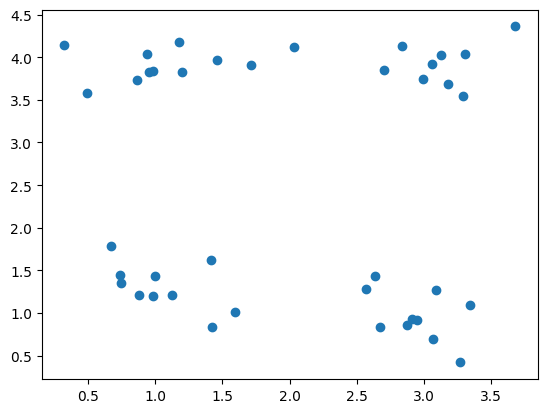

In [131]:
x_values = points[:,0]
y_values = points[:,1]
plt.scatter(x=x_values,y=y_values)

Wie erkennen also, dass wir vier verschiedene Cluster in unseren Daten haben. Dies sieht nach einem guten Anwendungsfall für *k-means*-Clustering aus. Bevor wir aber beginnen, den Clusteringalgorithmus zu implementieren fügen wir den Datenpunkten eine dritte Dimension für die Label des Clusters hinzu (vorläufig `-1`, da noch kein Label vorliegt) und betrachten, wie wir diese Label geschickt mitplotten können.

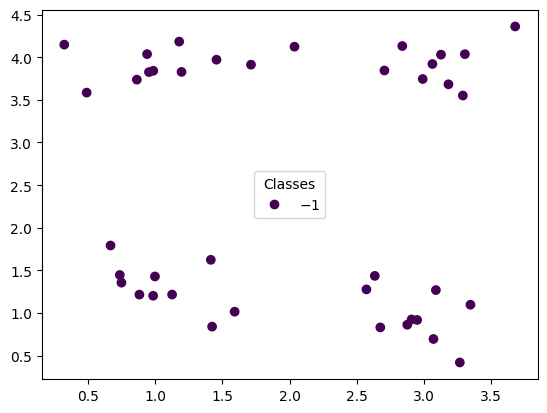

In [132]:
ones = np.ones((40,1))  # Erstellt ein ndarray aus 40 1-Werten
minus_ones = ones*-1    # Multipliziert jeden Wert im Array ones mit -1, sodass das Array aus -1 besteht.
points_with_labels = np.append(points, minus_ones, axis=1)  # Die negativen Labels werden als dritte Dimension an die Punkte angehängt
fig, ax = plt.subplots()  # Erstellt ein Plotobjekt
scatter = ax.scatter(x=x_values,y=y_values, c = minus_ones) # Fügt den eigentlichen Plot hinzu
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="center", title="Classes")  # Erstellt eine Legende


## Hilfsfunktionen für k-means

Wie wir bereits gesehen haben, ist es in Python möglich, verschiedene Funktionen aufzurufen. Natürlich ist es auch möglich, eigene Funktionen zu definieren. Funktionen werden durch `def name(parameter, getrennt, durch, Komma):` gefolgt von eingerückten Code definiert. Generell ersetzt die Einrückung in Python aus anderen Programmiersprachen bekannte Klammerungen. Im Folgenden definieren wir die Abstandsfunktion für zwei zweidimensionale Punkte und eine Funktion, die für einen gegebenen Punkt den Abstand zu allen Punkten in einer übergebenen Liste aus Punkten berechnet. Da Python eine nicht-typisierte Programmiersprache ist, müssen wir keine Dateitypen festlegen und können insofern theoretisch auch nicht sicher sein, dass die Eingaben in unsere Funktion der von uns gewünschten Form entsprechen. Aus diesem Grund stellen wir in der zweiten Funktion sicher, dass der Typ der Liste passend ist. In der Funktion `distance` gehen wir für dieses Tutorial davon aus, dass nur valide Werte übergeben werden.

In [133]:
def distance(point_a, point_b):
    x_a = point_a[0]
    y_a = point_a[1]
    x_b = point_b[0]
    y_b = point_b[1]
    sum = (x_a-x_b)**2+(y_a-y_b)**2     # Der Operator a**b entspricht der b-ten Potenz von as
    return np.sqrt(sum)     # Wir geben die Wurzel von sum zurück

def distance_to_list(point, list_of_points):
    if type(list_of_points) is np.ndarray:      # Sollten Sie ein ndarray übergeben, wandeln wir es an dieser Stelle in die von uns gewünschte Liste um
        list = []       # Erzeugen einer neuen Liste
        length = list_of_points.shape[0]      # Die Liste soll die Länge des nd-Arrays haben. Dies ist in unserem Fall die erste Dimension
        for i in range(0,length):       # Die for-Schleife besucht jeden Wert in range(0,length), was in diesem Fall jeder natürlichen Zahl in [0, length) entspricht
            list.append(list_of_points[i,0:2])  # Eine Zeile aus dem Array wird hinten an die Liste angehängt.
            # Für den Fall, dass auch Labels übergeben wurden, wird hier auch die zweite Dimension auf den x- und den y-Wert beschränkt
        list_of_points = list       # Das nd-Array wird nach Ende des Schleifendurchlaufs durch die Liste ersetzt.
    dist = 0
    for i in range(0,len(list_of_points)):
        dist += distance(point, list_of_points[i])   # a+=b entspricht a = a+b
    return dist

Mit diesen beiden Hilfsfunktionen sollte es nun möglich sein, ´**LLoyd's Algorithmus** zum Lösen des *k-means*-Problems zu implentieren.

## Lloyd's Algorithmus

*Lloyd's*-Algorithmus zum Finden von `k` Partitionen kann einfach implementiert werden. Er besteht aus folgenden Schritten:
1. Initialisierung: Wähle `k` zufällige Mittelwerte aus dem Datensatz
2. Zuordnung: Jeder Datenpunkt wird seinem nächsten Clustermittelpunkt zugeordnet
3. Aktualisierung: Jedes Clusterzentrum wird auf den Mittelwert der ihm zugeordneten Punkte gesetzt
4. Gehe zu Schritt 2 zurück, bis sich die Zuordnung der Punkte nicht mehr ändert.
Auch hier wollen wir zuerst modulare Teilfunktionen entwickeln, bevor wir den kompletten Algorithmus zusammensetzen

### Initialisierung

Initialisieren Sie die ersten `k` Clustermittelwerte durch Wählen von zufälligen Datenpunkten. Sie können davon ausgehen, dass die Eingabe ein ndarray in der oben gegebenen Form ist und die Punkte aus Liste von 2-Tupeln (`(wert1, wert2)`) zurückgeben. Eine Zufallszahl zwischen 0 und `n-1` erhalten Sie mittels `rng.integers(0,n)`.

In [134]:
def initialize (k, points):

    cluster_means = []
    for k in range(0,k):
        random = np.random.default_rng().integers(0, len(points))
        cluster_means.append(points[random, 0:2])
    
    return cluster_means

Mithilfe des folgenden Blocks können Sie kontrollieren, ob Ihre `initialize`-Methode jeweils `k` Elemente aus einem gegebenen Array wählt.

In [135]:
for k in range(1, 20):
    test_samples = rng.normal((3,4),0.3,(k*10,2))
    test_means = initialize(k, test_samples)
    if type(test_means) is not list:
        print("initialize("+str(k)+", test_samples) gibt keine Liste zurück")
        continue
    if len(test_means) != k:
        print("initialize("+str(k)+", test_samples) gibt nicht "+str(k)+" means wieder sondern "+str(len(test_means)))
        continue
    sample_points = test_samples.tolist()
    for mean in test_means:
        if mean.tolist() not in sample_points:
            print("initialize("+str(k)+", test_samples) gibt einen mean zurück, der kein Beispielpunkt ist")
print("Test beendet")

Test beendet


### Zuordnung

Jeder Datenpunkt wird seinem nächsten Clustermittelpunkt zugeordnet. Dabei entspricht das Label dem Index des entsprechenden Means in `means`. Hier können Sie davon ausgehen, dass Sie die Daten wie in `points_with_labels` vorliegen und die Clustermittelpunkte in einer Liste aus 2-Tupeln vorliegen. Sie können die Eingabe `points_with_labels` in place verändern, sodass sich dieses Array in einer aufrufenden Funktion durch das Aufrufen dieser Funktion verändert. Natürlich wäre auch ein Kopieren des Arrays möglich, bei dem die Zuordnungen in der Kopie verändert werden und diese Kopie zurückgegeben wird. Dies ist hier allerdings nicht vorgesehen und erfordert Anpassungen am von uns weiter unten bereitgestellten Gesamtalgorithmus. Geben Sie als Rückgabewert stattdessen an, ob sich mindestens ein Label während des Update-Vorgangs geändert hat.

In [136]:
def update_assignment(means, points_with_labels):
    updated = False

    for point in points_with_labels:
        dist_to_means = []

        for mean in means:
            dist_to_means.append(distance(point, mean))

        closest_center = np.argmin(dist_to_means)

        if (point[2] != closest_center) or (point[2] == -1):
            point[2] = closest_center
            updated = True
    
    return updated

Um Ihren Code der kommenden beiden Methoden zu testen, benötigen wir ein paar Testdaten, die wir in der nächsten Codezelle erstellen. Da der Code deterministisch ist, ist es valide, hier feste Arrays zu nutzen, da Ihre Methoden auf diesen Daten dieselben Ergebnisse erzielen sollten.

In [137]:
assign_test_points =np.array([[0.81978,1.17051,-1.00000],
[1.48120,0.96536,-1.00000],
[0.94599,0.31114,-1.00000],
[0.75984,0.93593,-1.00000],
[2.89074,4.21255,-1.00000],
[2.94237,4.12130,-1.00000],
[2.98080,3.50789,-1.00000],
[2.45449,4.12931,-1.00000],
[1.62633,4.56571,-1.00000],
[0.85234,4.52376,-1.00000],
[0.86853,3.77435,-1.00000],
[0.94646,4.04733,-1.00000],
[3.13563,0.99857,-1.00000],
[3.48784,0.50411,-1.00000],
[2.89875,1.06748,-1.00000],
[2.98594,0.82798,-1.00000]])
assign_1_results = np.array([[0.81978,1.17051,0.00000],
[1.48120,0.96536,0.00000],
[0.94599,0.31114,0.00000],
[0.75984,0.93593,0.00000],
[2.89074,4.21255,0.00000],
[2.94237,4.12130,0.00000],
[2.98080,3.50789,0.00000],
[2.45449,4.12931,0.00000],
[1.62633,4.56571,0.00000],
[0.85234,4.52376,0.00000],
[0.86853,3.77435,0.00000],
[0.94646,4.04733,0.00000],
[3.13563,0.99857,0.00000],
[3.48784,0.50411,0.00000],
[2.89875,1.06748,0.00000],
[2.98594,0.82798,0.00000]])
assign_2_results = np.array([[0.81978,1.17051,0.00000],
[1.48120,0.96536,0.00000],
[0.94599,0.31114,0.00000],
[0.75984,0.93593,0.00000],
[2.89074,4.21255,1.00000],
[2.94237,4.12130,1.00000],
[2.98080,3.50789,1.00000],
[2.45449,4.12931,1.00000],
[1.62633,4.56571,1.00000],
[0.85234,4.52376,1.00000],
[0.86853,3.77435,1.00000],
[0.94646,4.04733,1.00000],
[3.13563,0.99857,0.00000],
[3.48784,0.50411,0.00000],
[2.89875,1.06748,0.00000],
[2.98594,0.82798,0.00000]])
assign_3_results = np.array([[0.81978,1.17051,0.00000],
[1.48120,0.96536,0.00000],
[0.94599,0.31114,0.00000],
[0.75984,0.93593,0.00000],
[2.89074,4.21255,1.00000],
[2.94237,4.12130,1.00000],
[2.98080,3.50789,1.00000],
[2.45449,4.12931,1.00000],
[1.62633,4.56571,2.00000],
[0.85234,4.52376,2.00000],
[0.86853,3.77435,2.00000],
[0.94646,4.04733,2.00000],
[3.13563,0.99857,0.00000],
[3.48784,0.50411,0.00000],
[2.89875,1.06748,0.00000],
[2.98594,0.82798,0.00000]])
assign_4_results = np.array([[0.81978,1.17051,0.00000],
[1.48120,0.96536,0.00000],
[0.94599,0.31114,0.00000],
[0.75984,0.93593,0.00000],
[2.89074,4.21255,1.00000],
[2.94237,4.12130,1.00000],
[2.98080,3.50789,1.00000],
[2.45449,4.12931,1.00000],
[1.62633,4.56571,2.00000],
[0.85234,4.52376,2.00000],
[0.86853,3.77435,2.00000],
[0.94646,4.04733,2.00000],
[3.13563,0.99857,3.00000],
[3.48784,0.50411,3.00000],
[2.89875,1.06748,3.00000],
[2.98594,0.82798,3.00000]])

Nun können wir Ihre `update_assignment`-Methode testen.

In [138]:
# Kontrolle mit einem Mean
means = [np.array([1,1])]
check_updated = update_assignment(means, assign_test_points)
if check_updated is not True:
    print("1: Punkte ohne Label werden einem Mean nicht zugeordnet oder es wird ein falscher Wert zurückgegeben")
if -1.0 in assign_test_points[:,2]:
    print("1: Manche Punkte wurden keinem Cluster zugeordnet")
if (assign_test_points != assign_1_results).any():
    print("1: Punkte werden dem falschen Cluster zugeordnet")
check_updated = update_assignment(means, assign_test_points)
if check_updated is True:
    print("1: Beim zweiten Aufruf mit den selben Means wurde das Ergebnis verändert")
# Kontrolle mit 2 Means
means.append(np.array([3,4]))
check_updated = update_assignment(means, assign_test_points)
if check_updated is not True:
    print("2: Punkte werden nicht angepasst, obwohl dies nötig wäre oder es wird ein falscher Wert zurückgegeben")
if -1.0 in assign_test_points[:,2]:
    print("2: Manche Punkte wurden keinem Cluster zugeordnet")
if (assign_test_points != assign_2_results).any():
    print("2: Punkte werden dem falschen Cluster zugeordnet")
check_updated = update_assignment(means, assign_test_points)
if check_updated is True:
    print("2: Beim zweiten Aufruf mit den selben Means wurde das Ergebnis verändert")
# Kontrolle mit 3 Means
means.append(np.array([1,4]))
check_updated = update_assignment(means, assign_test_points)
if check_updated is not True:
    print("3: Punkte werden nicht angepasst, obwohl dies nötig wäre oder es wird ein falscher Wert zurückgegeben")
if -1.0 in assign_test_points[:,2]:
    print("3: Manche Punkte wurden keinem Cluster zugeordnet")
if (assign_test_points != assign_3_results).any():
    print("3: Punkte werden dem falschen Cluster zugeordnet")
check_updated = update_assignment(means, assign_test_points)
if check_updated is True:
    print("3: Beim zweiten Aufruf mit den selben Means wurde das Ergebnis verändert")
# Kontrolle mit 4 means
means.append(np.array([3,1]))
check_updated = update_assignment(means, assign_test_points)
if check_updated is not True:
    print("4: Punkte werden nicht angepasst, obwohl dies nötig wäre oder es wird ein falscher Wert zurückgegeben")
if -1.0 in assign_test_points[:,2]:
    print("4: Manche Punkte wurden keinem Cluster zugeordnet")
if (assign_test_points != assign_4_results).any():
    print("4: Punkte werden dem falschen Cluster zugeordnet")
check_updated = update_assignment(means, assign_test_points)
if check_updated is True:
    print("4: Beim zweiten Aufruf mit den selben Means wurde das Ergebnis verändert")
print("Test beendet")

Test beendet


### Aktualisierung

Im Aktualisierungsschritt werden die Clusterzentren so angepasst, dass sie dem Mittelwert der ihnen zugeordneten Punkte entsprechen. Gehen Sie hier davon aus, dass die means in einer Liste aus 2-Tupeln vorliegen und die Punkte wieder in einem 3-D Array mit labels. Geben Sie hier das Ergebnis der means aus, anstatt es in-place zu ändern. Sie können Teilarrays aus einem nd-Array erstellen, indem Sie eine Bedingung in das Feld der Indexierung schreiben, z.B. `A[A[:,0]==0]`, wenn Sie jede Zeile aus dem Array `A` erhalten wollen, deren Wert in der ersten Spalte `0` entspricht. Ein neues zweidimensionals Array können Sie erstellen mit zwei Zeilen und Spalten `np.array([a,b],[c,d])`. Offensichtlicherweise funktioniert dies ähnlich für Arrays mit mehr bzw. weniger Zeilen bzw. Spalten

In [139]:
def update_center(means, points_with_labels):
    
    recomputet_center = []
    for index, mean in enumerate(means):
        sum=np.array([0.0,0.0])
        count = 0
        assigned_points = points_with_labels[points_with_labels[:,2]==index][:,0:2]

        for point in assigned_points:
            sum+= point
            count +=1

        if count != 0:
            c = sum/count
            recomputet_center.append(c)
        else:
            c = rng.integers(0,points_with_labels.shape[0])
            recomputet_center.append(points_with_labels[c,0:2])

    return recomputet_center

Für den Test der `update`-Methode können wir wieder unsere vorher definierten Testmengen nutzen. Da es theoretisch möglich ist, dass einem Clusterzentrum hier keine Punkte zugewiesen werden kann es sinnvoll sein, diese Methode nichtdeterministisch zu implementieren und hier einen neuen, zufälligen Clustermittelpunkt zu vergeben. Dafür wird nur getestet, ob Ihr Programm irgendeinen Mean zurückgibt.

In [140]:
# Wir betrachten die vier Punkte, um die wir unsere Cluster generiert haben als Clustermittelpunkte
# Außerdem betrachten wir den ersten, die ersten beiden und die ersten drei Mittelpunkte jeweils einzeln, um die Implementierung mit einer unterschiedlichen Anzahl Cluster zu testen.
means1 = [np.array([1,1])]
means2 = [np.array([1,1]), np.array([3,4])]
means3 = [np.array([1,1]), np.array([3,4]), np.array([1,4])]
means4 = [np.array([1,1]), np.array([3,4]), np.array([1,4]), np.array([3,1])]
# Wir berechnen insgesamt 16 verschiedene Varianten. Zu jeder unserer 4 Mittelpunktmengen berechnen wir die neune Clustermittelpunkte für jedes der vier Clusterings, die wir beim Test der vorherigen Methode erstellt haben.
results_update = [[update_center(means1, assign_1_results), update_center(means1, assign_2_results), update_center(means1, assign_3_results), update_center(means1, assign_4_results)], [update_center(means2, assign_1_results), update_center(means2, assign_2_results), update_center(means2, assign_3_results), update_center(means2, assign_4_results)], [update_center(means3, assign_1_results), update_center(means3, assign_2_results), update_center(means3, assign_3_results), update_center(means3, assign_4_results)], [update_center(means4, assign_1_results), update_center(means4, assign_2_results), update_center(means4, assign_3_results), update_center(means4, assign_4_results)]]
for i in range(0,4):
    # Es wird geprüft, ob stehts die richtige Anzahl an Mittelpunkten widergegeben wird
    for j in range(0,4):
        if len(results_update[i][j])!=i+1:
            print(str(i+1)+": Es wurde die falsche Anzahl an Means ausgegeben:"+str(len(results_update[i][j])))
    # Der Mittelpunkt von Klasse 1 wird betratchet. Dieser ist in jeder Situation deterministisch.
    # Um Rundungsfehler abzufangen, wird hier nur betrachtet, ob der Wert nahe am gesuchten Wert ist.
    if distance(results_update[i][0][0], np.array([2.00481438, 2.478955]))>0.01:
        print(str(i+1)+".1.1: Es wurde ein falscher Mean ausgegeben.")
    if distance(results_update[i][1][0], np.array([2.06437125, 0.847635]))>0.01:
        print(str(i+1)+".2.1: Es wurde ein falscher Mean ausgegeben.")
    if distance(results_update[i][2][0], np.array([2.06437125, 0.847635]))>0.01:
        print(str(i+1)+".3.1: Es wurde ein falscher Mean ausgegeben.")
    if distance(results_update[i][3][0], np.array([1.0017025, 0.845735]))>0.01:
        print(str(i+1)+".4.1: Es wurde ein falscher Mean ausgegeben.")
    # Gibt es nur ein Cluster in den Daten, ergibt es keinen Sinn, die anderen Clustermittelpunkte zu betrachten
    if i == 0:
        continue
    # Der Mittelpunkt von Klasse 2 wird betrachtet. Wurden alle Punkte Cluster 1 zugeordnet, so ist dieser Punkt nicht bestimmt, weswegen ein Mittelpunkt nicht kontrolliert wird.
    if distance(results_update[i][1][1], np.array([1.94526,4.11028]))>0.01:
        print(str(i+1)+".2.2: Es wurde ein falscher Mean ausgegeben.")
    if distance(results_update[i][2][1], np.array([2.81710,3.99276]))>0.01:
        print(str(i+1)+".3.2: Es wurde ein falscher Mean ausgegeben.")
    if distance(results_update[i][3][1], np.array([2.81710,3.99276]))>0.01:
        print(str(i+1)+".4.2: Es wurde ein falscher Mean ausgegeben.")
    if i == 1:
        continue
    # Kontrolle vom dritten Mittelpunkt
    if distance(results_update[i][2][2], np.array([1.07342,4.22779]))>0.01:
        print(str(i+1)+".3.3: Es wurde ein falscher Mean ausgegeben.")
    if distance(results_update[i][3][2], np.array([1.07342,4.22779]))>0.01:
        print(str(i+1)+".4.3: Es wurde ein falscher Mean ausgegeben.")
    if i == 2:
        continue
    # Kontrolle vom vierten Mittelpunkt
    if distance(results_update[i][3][3], np.array([3.12704,0.84953]))>0.01:
        print(str(i+1)+".4.4: Es wurde ein falscher Mean ausgegeben.")
print("Test beendet")

Test beendet


### Gesamter Algorithmus

Mit diesen Hilfsfunktionen können Sie nun ohne weiteres *Lloyd's*-Algorithmus implementieren.

In [141]:
import math

def lloyd(k, points_with_labels):
    centers = initialize(k, points_with_labels)

    j = math.inf
    jnew = 0
    while j > jnew:
        j = jnew
        
        update_assignment(centers, points_with_labels)

        centers = update_center(centers, points_with_labels)

        for index, center in enumerate(centers):
            assigned_points = points_with_labels[points_with_labels[:,2]==index][:,0:2]
            jnew += distance_to_list(center, assigned_points)

    return points_with_labels

Nachdem Sie nun den Algorithmus implementiert haben, können Sie das Ergebnis des Algorithmus auf unseren Testdaten betrachten

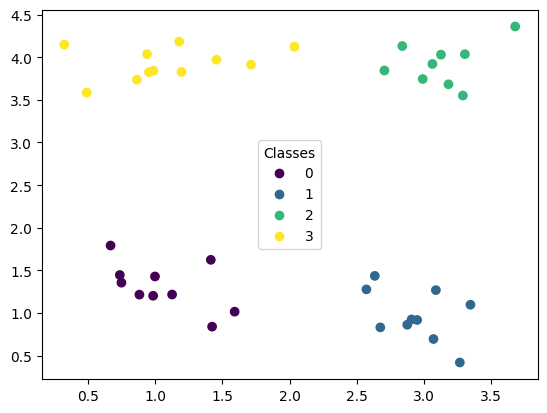

In [160]:
result = lloyd(4, points_with_labels)
fig, ax = plt.subplots()
scatter = ax.scatter(x=result[:,0],y=result[:,1], c = result[:,2])
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="center", title="Classes")

Wenn Sie den Algorithmus mehrmals ausführen, bemerken Sie wahrscheinlich, wie sich die Zuordnung der Punkte zu den Clustern mit jedem Durchlauf ändert. Dies liegt am starken Einfluss der initialisierten Mittelwerte, die wir in unserem Beispiel einfach zufällig gewählt haben. Wenn wir zum Beispiel unsere bei der Erstellung der Daten hardgecodeten Clusterzentren wählen bekommen wir immer das gleiche (wahrscheinlich gute) Ergebnis.
Herzlichen Glückwunsch, Sie haben erfolgreich *Lloyd's*-Algorithmus in Python implementiert